# Analysis of Antibiotics Prescription and Hospitalisation Risk

In [12]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import sklearn
# from sklearn.model_selection import train_test_split
%matplotlib inline

In [13]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit


In [14]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [15]:
def makeFilePath(pathFromWorkspace, fileName):
    workingdir = "/workspace/" if (os.name != "nt") else ""
    filepath = workingdir+pathFromWorkspace+fileName

    return filepath

In [16]:
# function to generate histogram plots
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [17]:
def create_lineplot(var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

In [18]:
def create_lineplot_hue(var, hue, title, legend_title, ax1):
    a = data_inclusions_exlusions.groupby(['date', var, hue]).size().reset_index()
    a.columns = ['date', var, hue, 'Freq']
    a = a[a[var] != 0]
    sns.lineplot(x='date', y='Freq', 
            hue=hue, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

## 1- Data Preparation

In [19]:
data2019_month = {}
data2020_month = {}
data2021_month = {}
data2019 = []
data2020 = []
data2021 = []
for  i in range(1, 13):
    # data of 2019
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-"+str(i).zfill(2)+"-01.csv.gz")
    data2019_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
    data2019.append(data2019_month["%s" %i])
    # data of 2020
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2020-"+str(i).zfill(2)+"-01.csv.gz")
    data2020_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2020_month["%s" %i]['date'] = "2020-"+str(i).zfill(2)
    data2020.append(data2020_month["%s" %i])
    # data of 2021
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2021-"+str(i).zfill(2)+"-01.csv.gz")
    data2021_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2021_month["%s" %i]['date'] = "2021-"+str(i).zfill(2)
    data2021.append(data2021_month["%s" %i])
    
data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)
data2020 = pd.concat(data2020_month, axis=0, ignore_index=True)
data2021 = pd.concat(data2021_month, axis=0, ignore_index=True)

data = data2019.append([data2020, data2021], ignore_index=True)

In [20]:
data.shape

(36000, 113)

In [21]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,antibacterial_prescriptions_date,sgss_positive,primary_care_covid,covrx1_dat,covrx2_dat,...,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,date
count,34200,3600,3600,3600,3600,90,3600,3600,0.0,0.0,...,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000
unique,37,37,37,13,7,29,1079,1076,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
top,2021-05,2021-03,2019-07,2018-06,2018-10,2019-01-15,2019-10-21,2021-06-29,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01
freq,1004,124,113,333,633,9,12,11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,5016.847028,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,2895.391822,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2505.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5025.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7538.000000,NaN


In [27]:
print(list(data.columns))

['bmi_date_measured', 'smoking_status_date', 'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med', 'flu_vaccine_clinical', 'antibacterial_prescriptions_date', 'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat', 'admitted_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'urti_date_1', 'urti_date_2', 'urti_date_3', 'urti_date_4', 'sinusitis_date_1', 'sinusitis_date_2', 'sinusitis_date_3', 'sinusitis_date_4', 'otmedia_date_1', 'otmedia_date_2', 'otmedia_date_3', 'otmedia_date_4', 'ot_externa_date_1', 'ot_externa_date_2', 'ot_externa_date_3', 'ot_externa_date_4', 'age', 'age_cat', 'sex', 'practice', 'region', 'msoa', 'imd', 'bmi', 'ethnicity', 'smoking_status', 'gp_count', 'flu_vaccine_tpp', 'flu_vaccine', 'antibacterial_prescriptions', 'antibacterial_brit', 'broad_spectrum_antibiotics_prescriptions', 'admitted', 'uti_counts', 'lrti_counts', 'urti_counts', 'sinusitis_counts', 'ot_exte

In [28]:
# define dictionaries

dict_sex = {'F': 'Female', 'M': 'Male'}
dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}

In [29]:
# reoplace values of dictionaries with existing ones

data = data.replace({"sex": dict_sex})
data = data.replace({"ethnicity": dict_ethnicity})
data = data.replace({"smoking_status": dict_smoking})
data = data.replace({"imd": dict_imd})
data = data.replace({"flu_vaccine": dict_flu})

In [30]:
#prep before plot

data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] <= 0] = np.nan

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

# Negative GP consultations mean what? Shall I remove them?

#### Calculating Chalson Comorbidity Index
Based on: https://www.nature.com/articles/4500889.pdf?origin=ppub

In [31]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [32]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1:
        n=n+1
    if data.iat[idx, col2] == 1:
        n=n+1 
    if data.iat[idx, col17] == 1:
        n=n+1 
    if data.iat[idx, col3] == 1:
        n=n+1
    if data.iat[idx, col7] == 1:
        n=n+1
    if data.iat[idx, col6] == 1:
        n=n+1
    if data.iat[idx, col16] == 1:
        n=n+1
    if data.iat[idx, col5] == 1:
        n=n+1
    if data.iat[idx, col12] == 1:
        n=n+1
    
    if data.iat[idx, col9] == 1:
        n=n+2
    if data.iat[idx, col14] == 1:
        n=n+2
    if data.iat[idx, col8] == 1:
        n=n+2
    if data.iat[idx, col1] == 1:
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma
    #    n=n+2

    if data.iat[idx, col13] == 1:
        n=n+3

    if data.iat[idx, col11] == 1:
        n=n+6
    if data.iat[idx, col10] == 1:
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

2.0     4812
3.0     4688
1.0     4233
4.0     4177
0.0     3394
5.0     3290
6.0     2870
7.0     2195
8.0     1754
9.0     1358
10.0    1080
11.0     756
12.0     535
13.0     330
14.0     214
15.0     120
16.0      84
17.0      50
18.0      29
19.0      15
20.0      11
21.0       3
22.0       2
Name: CCI, dtype: int64

In [33]:
data.age_cat

0         5-14
1         5-14
2        55-64
3        45-54
4        35-44
         ...  
35995    35-44
35996    65-74
35997    15-24
35998    15-24
35999    65-74
Name: age_cat, Length: 36000, dtype: object

In [34]:
# categorising 
data['BMI_cat'] = pd.cut(data['bmi'], right=False, bins=[0,18.5,25,30,200], labels=['Low', 'Moderate', 'High', 'very high'])
data['gp_count_cat'] = pd.cut(data['gp_count'], right=False, bins=[0,3,8,12,100], labels=['Few', 'Some', 'Many', 'Too many'])
data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,7,99], labels=['No', 'Low', 'Moderate', 'High', 'Very high'])
data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,200], labels=['0-17 years', '18-59 years', '>59 years'])
#data.CCI_cat.value_counts()

## 2- Plots

### 2-1- Continuous factors

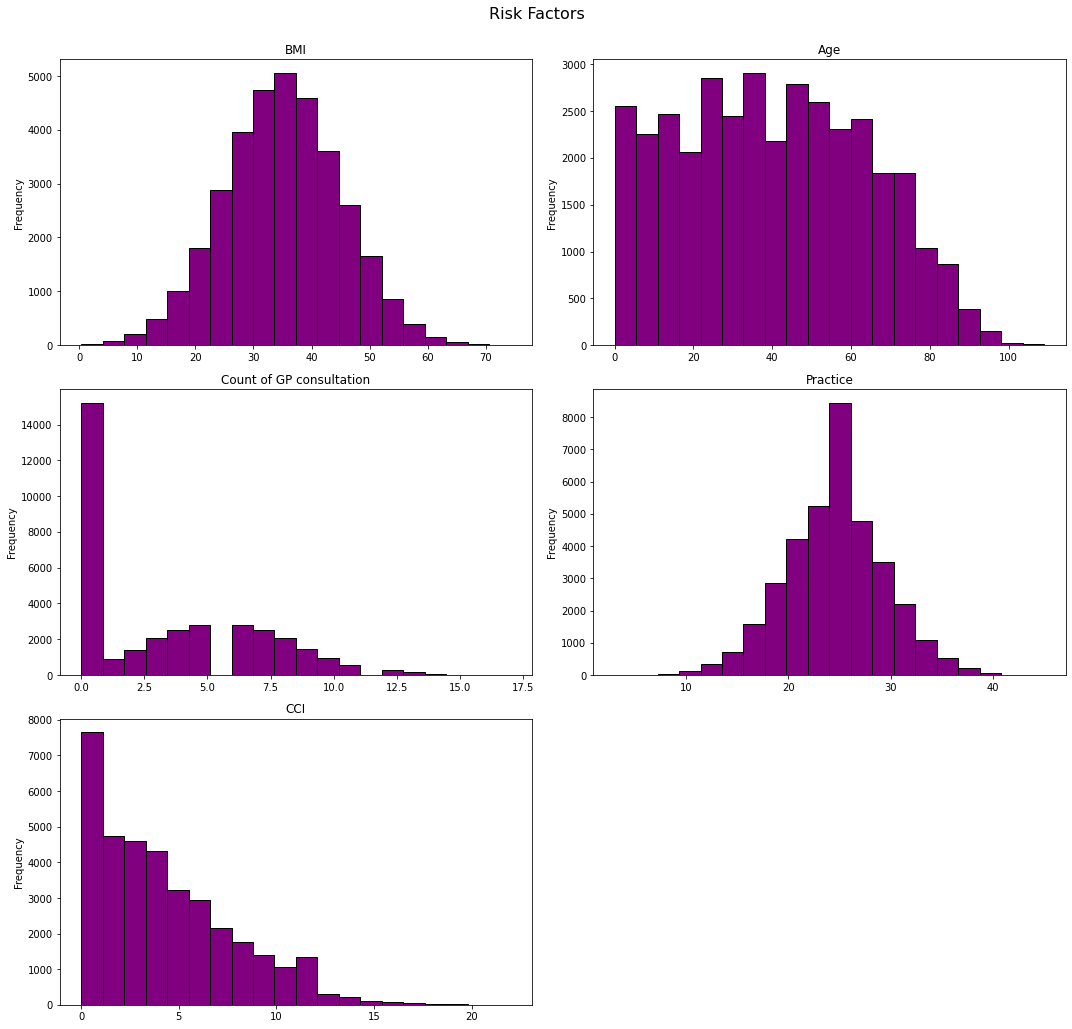

In [362]:
fig, axes = plt.subplots(3,2, 
                        figsize=(15, 15)
                        )
create_histplot('BMI', data['bmi'], axes[0,0])
create_histplot('Age', data['age'], axes[0,1])
create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
create_histplot('Practice', data['practice'], axes[1,1])
create_histplot('CCI', data['CCI'], axes[2,0])
fig.delaxes(ax=axes[2,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/risk_factors_cont.jpg')
plt.show()

In [35]:
print(list(data.columns))

['bmi_date_measured', 'smoking_status_date', 'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med', 'flu_vaccine_clinical', 'antibacterial_prescriptions_date', 'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat', 'admitted_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'urti_date_1', 'urti_date_2', 'urti_date_3', 'urti_date_4', 'sinusitis_date_1', 'sinusitis_date_2', 'sinusitis_date_3', 'sinusitis_date_4', 'otmedia_date_1', 'otmedia_date_2', 'otmedia_date_3', 'otmedia_date_4', 'ot_externa_date_1', 'ot_externa_date_2', 'ot_externa_date_3', 'ot_externa_date_4', 'age', 'age_cat', 'sex', 'practice', 'region', 'msoa', 'imd', 'bmi', 'ethnicity', 'smoking_status', 'gp_count', 'flu_vaccine_tpp', 'flu_vaccine', 'antibacterial_prescriptions', 'antibacterial_brit', 'broad_spectrum_antibiotics_prescriptions', 'admitted', 'uti_counts', 'lrti_counts', 'urti_counts', 'sinusitis_counts', 'ot_exte

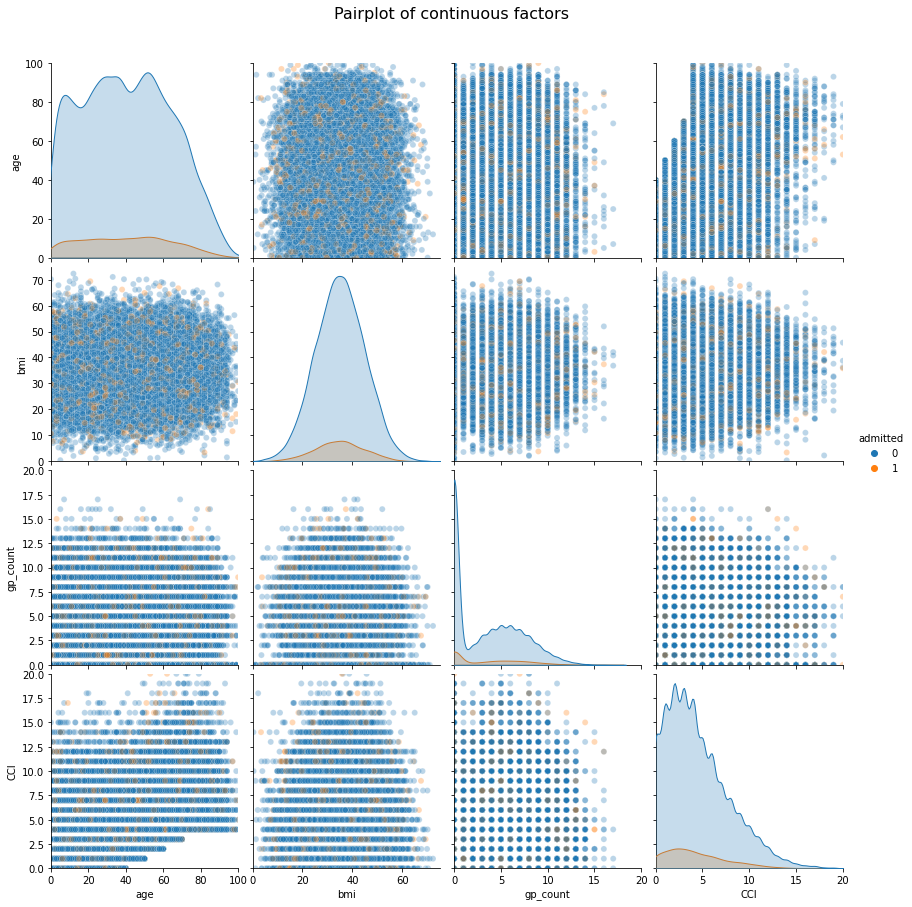

In [234]:
p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
                             ], 
                hue = 'admitted', # 'antibacterial_brit', 
#                kind='reg', 
                #markers=["o", "s"], 
                diag_kind="kde",#"hist"
#                plot_kws={#'line_kws':{'color':'red'}, 
                plot_kws={'alpha':0.3},
                height = 3)

p.axes[0,2].set_xlim((0,20))
p.axes[0,2].set_ylim((0,100))

p.axes[1,1].set_xlim((0,75))
p.axes[1,1].set_ylim((0,75))

p.axes[2,0].set_xlim((0,100))
p.axes[2,0].set_ylim((0,20))

p.axes[0,3].set_xlim((0,20))
p.axes[3,0].set_ylim((0,20))

plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
#plt.savefig('../output/hospitalisation_risk/risk_factors_cont_pairplot.jpg')
plt.show()

### 2-2- Categorical factors

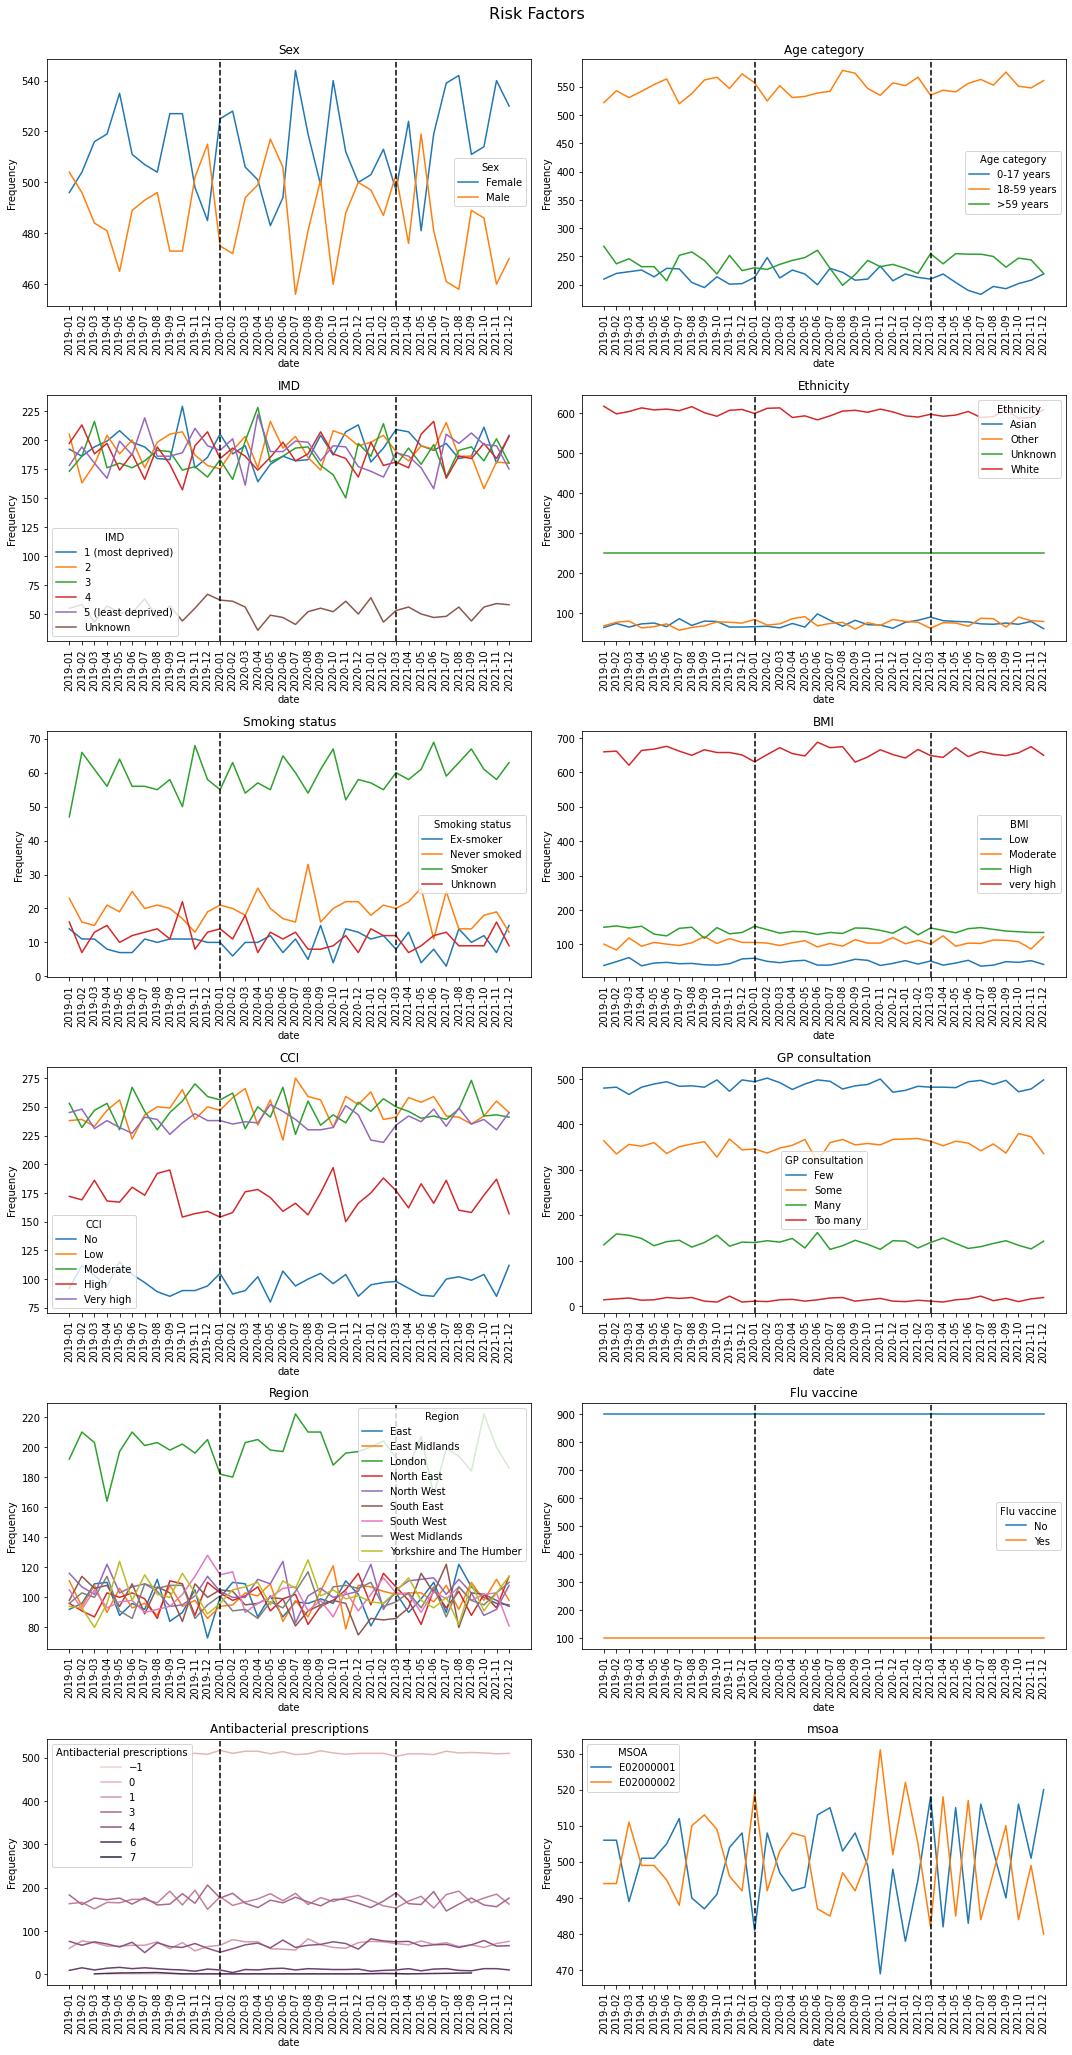

In [364]:
fig, axes = plt.subplots(6,2,
                        figsize=(15, 30)
                        )
create_lineplot('sex', 'Sex', 'Sex', axes[0,0])
create_lineplot('Age_cat', 'Age category', 'Age category', axes[0,1])
create_lineplot('imd', 'IMD', 'IMD', axes[1,0])
create_lineplot('ethnicity', 'Ethnicity', 'Ethnicity', axes[1,1])
create_lineplot('smoking_status', 'Smoking status', 'Smoking status', axes[2,0])
create_lineplot('BMI_cat', 'BMI', 'BMI', axes[2,1])
create_lineplot('CCI_cat', 'CCI', 'CCI', axes[3,0])
create_lineplot('gp_count_cat', 'GP consultation', 'GP consultation', axes[3,1])
create_lineplot('region', 'Region', 'Region', axes[4,0])
create_lineplot('flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
create_lineplot('antibacterial_brit', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
create_lineplot('msoa', 'msoa', 'MSOA', axes[5,1])
#fig.delaxes(ax=axes[4,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/risk_factors_cat.jpg')
plt.show()

## 3- Hospital admissions related to infections 

### 3-1- Data preparation for hospital admission prediction with negative binomial regression
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission. 

In [420]:
# # exclude period between January 2020 and March 2020

# # data['date'] = pd.to_datetime(data['date'], format="%Y%m", errors='coerce')
# # data['date']

# data = data[(data['date'] < '2020-01') | (data['date'] > '2020-03')]
# data.shape

In [365]:
data['uti_date_1'] = data['uti_date_1'].astype('datetime64[ns]')
data['uti_date_2'] = data['uti_date_2'].astype('datetime64[ns]')
data['uti_date_3'] = data['uti_date_3'].astype('datetime64[ns]')
data['uti_date_4'] = data['uti_date_4'].astype('datetime64[ns]')

data['lrti_date_1'] = data['lrti_date_1'].astype('datetime64[ns]')
data['lrti_date_2'] = data['lrti_date_2'].astype('datetime64[ns]')
data['lrti_date_3'] = data['lrti_date_3'].astype('datetime64[ns]')
data['lrti_date_4'] = data['lrti_date_4'].astype('datetime64[ns]')

data['primary_care_covid'] = data['primary_care_covid'].astype('datetime64[ns]')
data['sgss_positive'] = data['sgss_positive'].astype('datetime64[ns]')
data['admitted_date'] = data['admitted_date'].astype('datetime64[ns]')

In [366]:
data['delta_uti_1_admitted'] = (data['admitted_date'] - data['uti_date_1']).dt.days
data['delta_uti_2_admitted'] = (data['admitted_date'] - data['uti_date_2']).dt.days
data['delta_uti_3_admitted'] = (data['admitted_date'] - data['uti_date_3']).dt.days
data['delta_uti_4_admitted'] = (data['admitted_date'] - data['uti_date_4']).dt.days

data['delta_lrti_1_admitted'] = (data['admitted_date'] - data['lrti_date_1']).dt.days
data['delta_lrti_2_admitted'] = (data['admitted_date'] - data['lrti_date_2']).dt.days
data['delta_lrti_3_admitted'] = (data['admitted_date'] - data['lrti_date_3']).dt.days
data['delta_lrti_4_admitted'] = (data['admitted_date'] - data['lrti_date_4']).dt.days

In [367]:
# keep hospital admission within 30 days after infection diagnosis which refers to incident hospital admission

data['delta_uti_1_admitted'] = data['delta_uti_1_admitted'][(data['delta_uti_1_admitted'] < 30) & (data['delta_uti_1_admitted'] > 0)]
data['delta_uti_2_admitted'] = data['delta_uti_2_admitted'][(data['delta_uti_2_admitted'] < 30) & (data['delta_uti_2_admitted'] > 0)]
data['delta_uti_3_admitted'] = data['delta_uti_3_admitted'][(data['delta_uti_3_admitted'] < 30) & (data['delta_uti_3_admitted'] > 0)]
data['delta_uti_4_admitted'] = data['delta_uti_4_admitted'][(data['delta_uti_4_admitted'] < 30) & (data['delta_uti_4_admitted'] > 0)]

data['delta_lrti_1_admitted'] = data['delta_lrti_1_admitted'][(data['delta_lrti_1_admitted'] < 30) & (data['delta_lrti_1_admitted'] > 0)]
data['delta_lrti_2_admitted'] = data['delta_lrti_2_admitted'][(data['delta_lrti_2_admitted'] < 30) & (data['delta_lrti_2_admitted'] > 0)]
data['delta_lrti_3_admitted'] = data['delta_lrti_3_admitted'][(data['delta_lrti_3_admitted'] < 30) & (data['delta_lrti_3_admitted'] > 0)]
data['delta_lrti_4_admitted'] = data['delta_lrti_4_admitted'][(data['delta_lrti_4_admitted'] < 30) & (data['delta_lrti_4_admitted'] > 0)]

In [368]:
data['Infection_count'] = np.nan
col0 = data.columns.get_loc('Infection_count')

col1 = data.columns.get_loc('delta_uti_1_admitted')
col2 = data.columns.get_loc('delta_uti_2_admitted')
col3 = data.columns.get_loc('delta_uti_3_admitted')
col4 = data.columns.get_loc('delta_uti_4_admitted')
col5 = data.columns.get_loc('delta_lrti_1_admitted')
col6 = data.columns.get_loc('delta_lrti_2_admitted')
col7 = data.columns.get_loc('delta_lrti_3_admitted')
col8 = data.columns.get_loc('delta_lrti_4_admitted')


for idx, x in enumerate(data['Infection_count']):
    n=0
    #comorbidity component
    if data.iat[idx, col1] > 0:
        n=n+1
    if data.iat[idx, col2] > 0:
        n=n+1 
    if data.iat[idx, col3] > 0:
        n=n+1 
    if data.iat[idx, col4] > 0:
        n=n+1
    if data.iat[idx, col5] > 0:
        n=n+1
    if data.iat[idx, col6] > 0:
        n=n+1
    if data.iat[idx, col7] > 0:
        n=n+1
    if data.iat[idx, col8] > 0:
        n=n+1
    data.iat[idx, col0]=n

data.Infection_count.value_counts()

# data.loc[data.Infection_count == 2]

0.0    35753
1.0      244
2.0        3
Name: Infection_count, dtype: int64

In [369]:
# add a column with the closest duration from hospitalisation
data['Infection_admitted_min_delta'] = data[['delta_uti_1_admitted','delta_uti_2_admitted', 'delta_uti_3_admitted', 
                                            'delta_uti_4_admitted', 'delta_lrti_1_admitted', 'delta_lrti_2_admitted',
                                            'delta_lrti_3_admitted', 'delta_lrti_4_admitted']].min(axis=1)

data['Infection_admitted_min_delta'].value_counts().sum()

247

In [370]:
#data['Infection_admitted_min_delta'].value_counts()

In [371]:
print(f'Data shape is: {data.shape}')

Data shape is: (36000, 91)


In [372]:
data.columns

Index(['bmi_date_measured', 'smoking_status_date',
       'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med',
       'flu_vaccine_clinical', 'antibacterial_prescriptions_date',
       'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat',
       'admitted_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3',
       'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3',
       'lrti_date_4', 'age', 'age_cat', 'sex', 'practice', 'region', 'msoa',
       'imd', 'bmi', 'ethnicity', 'smoking_status', 'gp_count',
       'flu_vaccine_tpp', 'flu_vaccine', 'antibacterial_prescriptions',
       'antibacterial_brit', 'broad_spectrum_antibiotics_prescriptions',
       'admitted', 'uti_counts', 'lrti_counts', 'urti_counts',
       'sinusitis_counts', 'ot_externa_counts', 'otmedia_counts', 'uti_pt',
       'lrti_pt', 'urti_pt', 'sinusitis_pt', 'ot_externa_pt', 'otmedia_pt',
       'uti_ab_count_1', 'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4',
       'lrti_ab_c

In [373]:
# combine two columns of records for Covid-19 diagnosis: sgss and primary care records
data['combine_sgss_pos_primary_care_covid'] = data['sgss_positive'].combine_first(data['primary_care_covid'])
# data.loc[1:50, ['sgss_positive', 'primary_care_covid', 'combine_sgss_pos_primary_care_covid']]
data['combine_sgss_pos_primary_care_covid'].value_counts()

2021-07-08    15
2019-07-01    15
2020-09-16    15
2020-11-06    15
2021-07-03    13
              ..
2021-05-10     1
2021-08-28     1
2019-05-22     1
2019-11-29     1
2021-12-09     1
Name: combine_sgss_pos_primary_care_covid, Length: 1077, dtype: int64

In [374]:
# calculation of delta of hospital admission date and diagnosis of covid (sgss and primary care)
#data['delta_primary_care_covid_admitted'] = (data['admitted_date'] - data['primary_care_covid']).dt.days
data['delta_sgss_covid_admitted'] = (data['admitted_date'] - data['combine_sgss_pos_primary_care_covid']).dt.days
data['delta_sgss_covid_admitted'].value_counts()

 46.0      6
 13.0      6
 80.0      5
-68.0      5
 361.0     5
          ..
 275.0     1
 829.0     1
 861.0     1
-965.0     1
-1000.0    1
Name: delta_sgss_covid_admitted, Length: 1186, dtype: int64

In [375]:
data['delta_sgss_covid_admitted'].value_counts().sum()

2030

In [376]:

data['delta_sgss_covid_admitted'] = data['delta_sgss_covid_admitted'][(data['delta_sgss_covid_admitted'] < 390) & (data['delta_sgss_covid_admitted'] > -330)]
data['delta_sgss_covid_admitted'].value_counts().sum()

1116

In [377]:
# calculate absolute values for all rows in delta_primary_care_covid_admitted column
data['delta_sgss_covid_admitted_abs'] = data['delta_sgss_covid_admitted'].abs()

data['delta_sgss_covid_admitted_abs'].value_counts()

46.0     10
80.0     10
77.0      9
67.0      9
13.0      8
         ..
312.0     1
335.0     1
278.0     1
337.0     1
241.0     1
Name: delta_sgss_covid_admitted_abs, Length: 357, dtype: int64

In [378]:
data['delta_sgss_covid_admitted_abs'].value_counts().sum()

1116

In [379]:
data['delta_sgss_covid_admitted_binary'] = data['delta_sgss_covid_admitted_abs'].mask(data['delta_sgss_covid_admitted_abs'] > 0, 1)
data['delta_sgss_covid_admitted_binary'] = data['delta_sgss_covid_admitted_binary'].fillna(0)
data['delta_sgss_covid_admitted_binary'].sum()
# data['delta_sgss_covid_admitted_binary'].value_counts()

1116.0

In [380]:
data['delta_sgss_covid_admitted_binary'].value_counts()

0.0    34884
1.0     1116
Name: delta_sgss_covid_admitted_binary, dtype: int64

In [381]:
#data.Infection_admitted_min_delta.value_counts()#.sum()

In [382]:
data.delta_sgss_covid_admitted_binary.value_counts()

0.0    34884
1.0     1116
Name: delta_sgss_covid_admitted_binary, dtype: int64

In [383]:
data['Infection_admitted_min_delta_delta_sgss_covid_admitted_binary'] = np.nan
col0 = data.columns.get_loc('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary')

col1 = data.columns.get_loc('Infection_admitted_min_delta')
col2 = data.columns.get_loc('delta_sgss_covid_admitted_binary')


for idx, x in enumerate(data['Infection_admitted_min_delta_delta_sgss_covid_admitted_binary']):
    n=0
    if data.iat[idx, col1] >= 1 and data.iat[idx, col2] == 1:
        n=n+1
    data.iat[idx, col0]=n

data['Infection_admitted_min_delta_delta_sgss_covid_admitted_binary'].value_counts()

# data.loc[data.Infection_count == 2]

0.0    35972
1.0       28
Name: Infection_admitted_min_delta_delta_sgss_covid_admitted_binary, dtype: int64

In [384]:
data.delta_sgss_covid_admitted_binary.value_counts()

0.0    34884
1.0     1116
Name: delta_sgss_covid_admitted_binary, dtype: int64

### 3-2- Plots of hospitalisation

In [385]:
# # sort data with date records
# data = data.sort_values(by='date')
# data

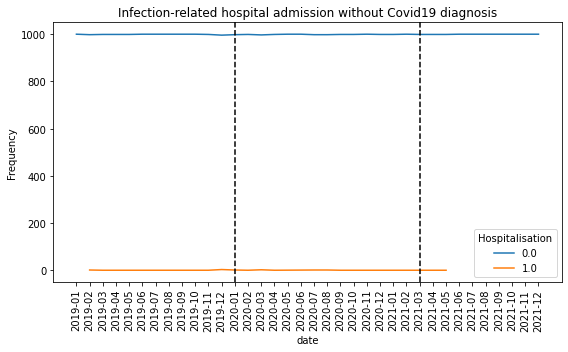

In [386]:
fig, ax = plt.subplots(figsize=(8, 5))

create_lineplot('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'Infection-related hospital admission without Covid19 diagnosis', 'Hospitalisation', ax)

plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/infection-related_hospitalisation.jpg')
plt.show()

### 3-3- Data inclusions and exclusions

In [387]:
# inclusion applied
data_inclusions = data[data['Infection_admitted_min_delta'].notnull()]
print(f'The shape of data with hospitalisation inclusion criterion is: {data_inclusions.shape}')

The shape of data with hospitalisation inclusion criterion is: (247, 96)


In [388]:
# exclusion applied
data_inclusions_exlusions = data_inclusions[(data_inclusions['delta_sgss_covid_admitted'] < 390) & (data_inclusions['delta_sgss_covid_admitted'] > -330)]  # exclusions shold be <90  and >-30
print(f'The shape of data with hospitalisation inclusion criterion and covid diagnosis (sgss) exclusion criterion is: {data_inclusions_exlusions.shape}')

The shape of data with hospitalisation inclusion criterion and covid diagnosis (sgss) exclusion criterion is: (28, 96)


In [389]:
data_inclusions_exlusions['delta_sgss_covid_admitted'].value_counts()

-68.0     1
 330.0    1
-75.0     1
 68.0     1
-33.0     1
-233.0    1
 80.0     1
 52.0     1
-97.0     1
 286.0    1
-169.0    1
-328.0    1
 220.0    1
-307.0    1
 335.0    1
-303.0    1
 78.0     1
-146.0    1
-282.0    1
-293.0    1
 167.0    1
 139.0    1
 251.0    1
-36.0     1
-306.0    1
-120.0    1
-268.0    1
 106.0    1
Name: delta_sgss_covid_admitted, dtype: int64

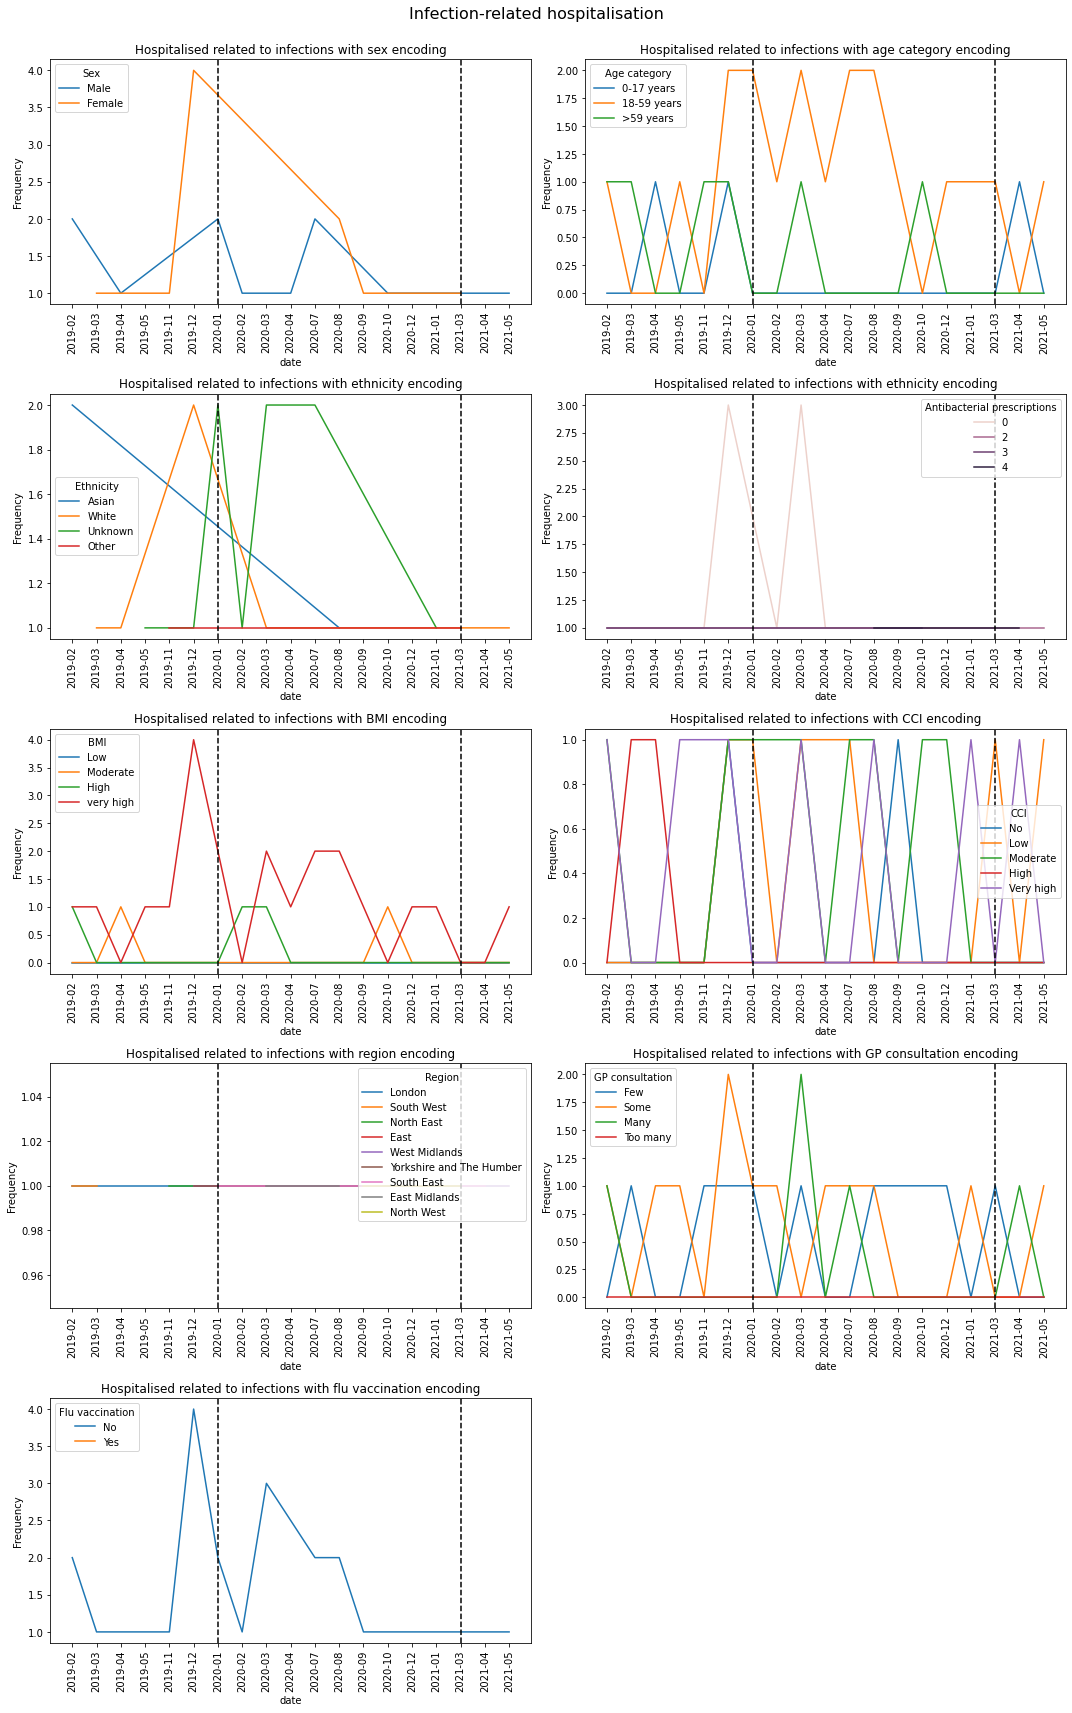

In [390]:
fig, axes = plt.subplots(5,2,
                        figsize=(15, 25)
                        )

create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'sex', 'Hospitalised related to infections with sex encoding', 'Sex', axes[0,0])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'Age_cat', 'Hospitalised related to infections with age category encoding', 'Age category', axes[0,1])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'ethnicity', 'Hospitalised related to infections with ethnicity encoding', 'Ethnicity', axes[1,0])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'antibacterial_brit', 'Hospitalised related to infections with ethnicity encoding', 'Antibacterial prescriptions', axes[1,1])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'BMI_cat', 'Hospitalised related to infections with BMI encoding', 'BMI', axes[2,0])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'CCI_cat', 'Hospitalised related to infections with CCI encoding', 'CCI', axes[2,1])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'region', 'Hospitalised related to infections with region encoding', 'Region', axes[3,0])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'gp_count_cat', 'Hospitalised related to infections with GP consultation encoding', 'GP consultation', axes[3,1])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'flu_vaccine', 'Hospitalised related to infections with flu vaccination encoding', 'Flu vaccination', axes[4,0])
# create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'covrx1_dat', 'Hospitalised related to infections with encoding of 1st Covid-19 Vaccine', '1st dose of Covid-19 vaccination', axes[5,0])
# create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'covrx2_dat', 'Hospitalised related to infections with encoding of 2nd Covid-19 Vaccine', '2nd dose of Covid-19 vaccination', axes[5,1])
fig.delaxes(ax=axes[4,1])

fig.suptitle('Infection-related hospitalisation', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/infection-related_hospitalisation_inclusion_exclusion_applied.jpg')
plt.show()

### 3-4- Negative binomial regression
#### Data preparation

In [424]:
data_inclusions_exlusions.shape

(28, 96)

In [425]:
# exclude period between January 2020 and March 2020

# data['date'] = pd.to_datetime(data['date'], format="%Y%m", errors='coerce')
# data['date']

data_inclusions_exlusions = data_inclusions_exlusions[(data_inclusions_exlusions['date'] < '2020-01') | (data_inclusions_exlusions['date'] > '2020-03')]
data_inclusions_exlusions.shape

(22, 96)

In [426]:
data_inclusions_exlusions.date

1102     2019-02
1671     2019-02
2302     2019-03
3261     2019-04
4351     2019-05
10471    2019-11
11118    2019-12
11151    2019-12
11359    2019-12
11382    2019-12
15369    2020-04
18225    2020-07
18697    2020-07
19618    2020-08
19928    2020-08
20480    2020-09
21668    2020-10
23812    2020-12
24057    2021-01
26197    2021-03
27243    2021-04
28862    2021-05
Name: date, dtype: object

In [427]:
# define dictionaries

# dict_sex = {'Female': 1, 'Male': 2}
# dict_ethnicity = {'White': 1, 'Mixed': 2, 'Asian': 3, 'Black': 4, 'Other': 5, 'Unknown': 0}
# dict_smoking = {'Ex-smoker': 1, 'Unknown': 2, 'Smoker': 3, 'Never smoked': 4, np.nan: 2}
dict_imd = {'Unknown': 0, '1 (most deprived)': 1, '2': 2, '3': 3, '4': 4, '5 (least deprived)': 5}
dict_flu = {'No': 0, 'Yes': 1}
#dic_delta_primary_care_covid_admitted_abs = {'No': 0, 'Yes': 1}

# reoplace values of dictionaries with existing ones

# data_inclusions_exlusions = data_inclusions_exlusions.replace({"sex": dict_sex})
# data_inclusions_exlusions = data_inclusions_exlusions.replace({"ethnicity": dict_ethnicity})
# data_inclusions_exlusions = data_inclusions_exlusions.replace({"smoking_status": dict_smoking})
data_inclusions_exlusions = data_inclusions_exlusions.replace({"imd": dict_imd})
data_inclusions_exlusions = data_inclusions_exlusions.replace({"flu_vaccine": dict_flu})

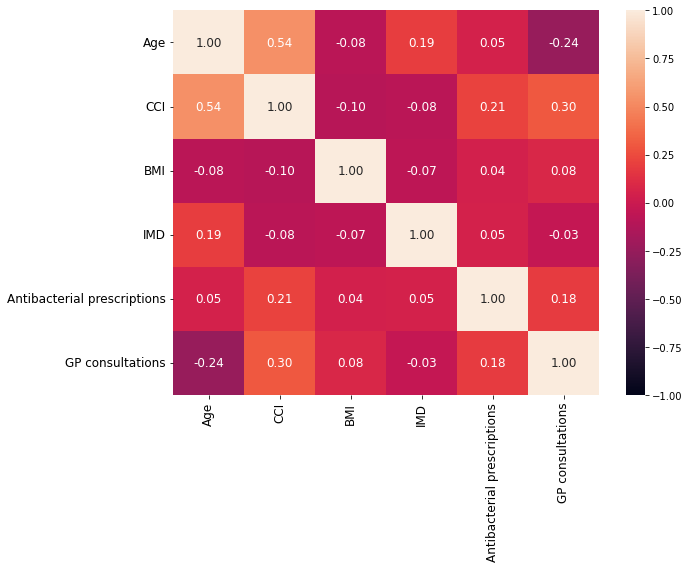

In [428]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_inclusions_exlusions[['age','CCI','bmi', 'imd', 'antibacterial_brit', 'gp_count']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age','CCI','BMI', 'IMD', 'Antibacterial prescriptions', 'GP consultations'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age','CCI','BMI', 'IMD', 'Antibacterial prescriptions', 'GP consultations'], rotation=0, fontsize=12)                        
plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/corr_hospitalisation.jpg')
plt.show()

In [429]:
# # select patients whom their delta date is between 90 and -30
# data_hosp = data[~data['delta_primary_care_covid_admitted'].isnull()]
# data_hosp.head()

In [430]:
data_inclusions_exlusions#['delta_primary_care_covid_admitted_abs']

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,antibacterial_prescriptions_date,sgss_positive,primary_care_covid,covrx1_dat,covrx2_dat,...,delta_lrti_2_admitted,delta_lrti_3_admitted,delta_lrti_4_admitted,Infection_count,Infection_admitted_min_delta,combine_sgss_pos_primary_care_covid,delta_sgss_covid_admitted,delta_sgss_covid_admitted_abs,delta_sgss_covid_admitted_binary,Infection_admitted_min_delta_delta_sgss_covid_admitted_binary
1102,2020-08,NaN,NaN,NaN,NaN,NaN,NaT,2019-04-10,NaN,NaN,...,22.0,NaN,NaN,1.0,22.0,2019-04-10,-68.0,68.0,1.0,1.0
1671,2021-01,NaN,NaN,NaN,NaN,NaN,NaT,2020-04-14,NaN,NaN,...,NaN,NaN,NaN,1.0,16.0,2020-04-14,330.0,330.0,1.0,1.0
2302,2019-03,NaN,NaN,NaN,NaN,NaN,2020-11-23,NaT,NaN,NaN,...,NaN,NaN,NaN,1.0,26.0,2020-11-23,-268.0,268.0,1.0,1.0
3261,2020-01,NaN,2021-04,2018-12,NaN,NaN,NaT,2021-06-21,NaN,NaN,...,NaN,NaN,6.0,1.0,6.0,2021-06-21,-120.0,120.0,1.0,1.0
4351,2019-06,NaN,NaN,NaN,NaN,NaN,2021-03-02,NaT,NaN,NaN,...,NaN,NaN,NaN,1.0,24.0,2021-03-02,-306.0,306.0,1.0,1.0
10471,2020-02,NaN,NaN,NaN,NaN,NaN,NaT,2020-12-28,NaN,NaN,...,NaN,NaN,NaN,1.0,25.0,2020-12-28,-36.0,36.0,1.0,1.0
11118,2021-01,NaN,NaN,NaN,NaN,NaN,2019-02-10,NaT,NaN,NaN,...,NaN,NaN,NaN,1.0,19.0,2019-02-10,251.0,251.0,1.0,1.0
11151,2021-01,NaN,NaN,NaN,NaN,NaN,NaT,2019-02-21,NaN,NaN,...,NaN,NaN,NaN,1.0,28.0,2019-02-21,139.0,139.0,1.0,1.0
11359,2019-07,NaN,NaN,NaN,NaN,NaN,2019-02-03,NaT,NaN,NaN,...,NaN,NaN,NaN,1.0,22.0,2019-02-03,167.0,167.0,1.0,1.0
11382,2019-03,NaN,NaN,NaN,NaN,NaN,2020-05-07,NaT,NaN,NaN,...,NaN,NaN,NaN,1.0,11.0,2020-05-07,-293.0,293.0,1.0,1.0


In [324]:
# # assigning 0 to NaN cells of delta_primary_care_covid_admitted_abs for compatibility of NB model
# data['delta_primary_care_covid_admitted_abs'] = data['delta_primary_care_covid_admitted_abs'].fillna(0)
# data['delta_primary_care_covid_admitted_abs'].value_counts()

In [118]:
# # define dictionaries

# # dict_sex = {'Female': 1, 'Male': 2}
# # dict_ethnicity = {'White': 1, 'Mixed': 2, 'Asian': 3, 'Black': 4, 'Other': 5, 'Unknown': 0}
# # dict_smoking = {'Ex-smoker': 1, 'Unknown': 2, 'Smoker': 3, 'Never smoked': 4, np.nan: 2}
# dict_imd = {'Unknown': 0, '1 (most deprived)': 1, '2': 2, '3': 3, '4': 4, '5 (least deprived)': 5}
# dict_flu = {'No': 0, 'Yes': 1}
# #dic_delta_primary_care_covid_admitted_abs = {'No': 0, 'Yes': 1}

# # reoplace values of dictionaries with existing ones

# # data_inclusions_exlusions = data_inclusions_exlusions.replace({"sex": dict_sex})
# # data_inclusions_exlusions = data_inclusions_exlusions.replace({"ethnicity": dict_ethnicity})
# # data_inclusions_exlusions = data_inclusions_exlusions.replace({"smoking_status": dict_smoking})
# data_inclusions_exlusions = data_inclusions_exlusions.replace({"imd": dict_imd})
# data_inclusions_exlusions = data_inclusions_exlusions.replace({"flu_vaccine": dict_flu})

In [399]:
data_inclusions_exlusions.columns

Index(['bmi_date_measured', 'smoking_status_date',
       'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med',
       'flu_vaccine_clinical', 'antibacterial_prescriptions_date',
       'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat',
       'admitted_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3',
       'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3',
       'lrti_date_4', 'age', 'age_cat', 'sex', 'practice', 'region', 'msoa',
       'imd', 'bmi', 'ethnicity', 'smoking_status', 'gp_count',
       'flu_vaccine_tpp', 'flu_vaccine', 'antibacterial_prescriptions',
       'antibacterial_brit', 'broad_spectrum_antibiotics_prescriptions',
       'admitted', 'uti_counts', 'lrti_counts', 'urti_counts',
       'sinusitis_counts', 'ot_externa_counts', 'otmedia_counts', 'uti_pt',
       'lrti_pt', 'urti_pt', 'sinusitis_pt', 'ot_externa_pt', 'otmedia_pt',
       'uti_ab_count_1', 'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4',
       'lrti_ab_c

In [400]:
data_NB = data_inclusions_exlusions.groupby(['Infection_admitted_min_delta']).sum()#.reset_index()
#data_NB = data_NB.drop([0])
data_NB#.head()

,covrx1_dat,covrx2_dat,age,practice,imd,bmi,gp_count,flu_vaccine_tpp,flu_vaccine,antibacterial_prescriptions,...,delta_uti_4_admitted,delta_lrti_1_admitted,delta_lrti_2_admitted,delta_lrti_3_admitted,delta_lrti_4_admitted,Infection_count,delta_sgss_covid_admitted,delta_sgss_covid_admitted_abs,delta_sgss_covid_admitted_binary,Infection_admitted_min_delta_delta_sgss_covid_admitted_binary
Infection_admitted_min_delta,,,,,,,,,,,,,,,,,,,,,
4.0,0.0,0.0,68,41,6,89.861732,3.0,0,0,4,...,0.0,0.0,0.0,0.0,0.0,2.0,-330.0,330.0,2.0,2.0
6.0,0.0,0.0,43,51,4,78.821614,9.0,0,0,2,...,0.0,0.0,0.0,6.0,6.0,2.0,-448.0,448.0,2.0,2.0
8.0,0.0,0.0,26,27,1,26.438409,0.0,0,0,0,...,8.0,0.0,0.0,0.0,0.0,1.0,-307.0,307.0,1.0,1.0
11.0,0.0,0.0,15,31,0,37.678499,0.0,0,0,0,...,0.0,11.0,0.0,0.0,0.0,1.0,-293.0,293.0,1.0,1.0
16.0,0.0,0.0,56,27,4,48.081742,7.0,0,0,3,...,0.0,0.0,0.0,0.0,0.0,1.0,330.0,330.0,1.0,1.0
17.0,0.0,0.0,106,55,7,71.683337,6.0,0,0,6,...,0.0,0.0,0.0,17.0,0.0,2.0,-315.0,315.0,2.0,2.0
19.0,0.0,0.0,88,116,10,112.240608,24.0,0,0,7,...,19.0,0.0,0.0,19.0,0.0,4.0,82.0,524.0,4.0,4.0
20.0,0.0,0.0,42,30,2,0.000000,2.0,0,0,0,...,0.0,0.0,0.0,20.0,0.0,1.0,68.0,68.0,1.0,1.0
22.0,0.0,0.0,96,37,5,62.382232,9.0,0,0,5,...,22.0,0.0,22.0,0.0,0.0,2.0,99.0,235.0,2.0,2.0


In [416]:
data_NB.Infection_count

Infection_admitted_min_delta
4.0     2.0
6.0     2.0
8.0     1.0
11.0    1.0
16.0    1.0
17.0    2.0
19.0    4.0
20.0    1.0
22.0    2.0
24.0    3.0
25.0    2.0
26.0    1.0
27.0    2.0
28.0    4.0
Name: Infection_count, dtype: float64

In [401]:
# data_NB = data_inclusions_exlusions.groupby(['admitted_date', 'Infection_admitted_min_delta']).mean()#.reset_index()
# #data_NB = data_NB.drop([0])
# data_NB#.head()

In [402]:
# data_NB.index#.admitted_date

In [417]:
X = data_NB[['Infection_count'
#          'age', 
#          'sex',
#          'bmi',
#          'ethnicity', 
#          'smoking_status',
#          'gp_count',
#          'CCI',
#          'imd',
#          'flu_vaccine',
#          'antibacterial_brit',
#          'delta_primary_care_covid_admitted_abs',
          ]]

y = data_NB.index
#y = data_NB.index.get_level_values(1) 

In [418]:
nb2_training_results = sm.GLM(y, 
                              X,
                              family=sm.families.NegativeBinomial(alpha=1)).fit()

In [419]:
nb2_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   14
Model:                            GLM   Df Residuals:                       13
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -64.908
Date:                Mon, 17 Jan 2022   Deviance:                       23.612
Time:                        16:53:12   Pearson chi2:                     41.9
No. Iterations:                    14   Pseudo R-squ. (CS):             -3.177
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Infection_count     1.4771      0.122     12.152      0.000       1.239       1.715
===================================================================================
"""

In [406]:
# nb2_training_results.summary2()

In [292]:
# nb2_training_results.conf_int()

In [291]:
# err_series = nb2_training_results.params - nb2_training_results.conf_int()[0]
# err_series

In [290]:
# coef_df = pd.DataFrame({'coef': nb2_training_results.params.values[0:],
#                         'err': err_series.values[0:],
#                         'varname': err_series.index.values[0:]
#                        })
# coef_df

##### 3-4-1- Plot effect of predictors

In [289]:
# fig, ax = plt.subplots(figsize=(8, 5))
# fig.suptitle('Effect of predictors on hospitalisation', fontsize=16)
# ax.errorbar(x=coef_df['coef'], y=coef_df['varname'], xerr=coef_df['err'], fmt='o', color='black',
#              ecolor='darkgray', elinewidth=3)
# # ax1.set_title('variable, asymmetric error')
# # ax1.set_yscale('log')
# ax.axvline(x=0, linestyle='--', color='black', linewidth=2)
# #ax.xaxis.set_ticks_position('none')
# _ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=0, fontsize=12)

# plt.xlabel('', fontsize='14')
# # plt.ylim(0,10)
# plt.tight_layout()
# #plt.savefig('../output/hospitalisation_risk/effect_hospitalisation.jpg')
# plt.show()

In [288]:
# fig, ax = plt.subplots(figsize=(8, 5))
# fig.suptitle('Effect of predictors on hospitalisation', fontsize=16)
# coef_df.plot(x='varname', y='coef', kind='bar', 
#              ax=ax, color='none', 
#              yerr='err', legend=False)
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
#            marker='s', s=120, 
#            y=coef_df['coef'], color='black')
# ax.axhline(y=0, linestyle='--', color='black', linewidth=2)
# #ax.xaxis.set_ticks_position('none')
# _ = ax.set_xticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')

# plt.tight_layout()
# #plt.savefig('../output/hospitalisation_risk/effect_hospitalisation_vert.jpg')
# plt.show()

##### 3-4-2- Plot predictions and actual values

In [407]:
# nb2_predictions = nb2_training_results.get_prediction(X_test)
nb2_predictions = nb2_training_results.get_prediction(X)

In [408]:
nb2predictions_summary_frame = nb2_predictions.summary_frame()
print(nb2predictions_summary_frame)

                                    mean     mean_se  mean_ci_lower  \
Infection_admitted_min_delta                                          
4.0                            19.184821    4.663677      11.913446   
6.0                            19.184821    4.663677      11.913446   
8.0                             4.380048    0.532377       3.451586   
11.0                            4.380048    0.532377       3.451586   
16.0                            4.380048    0.532377       3.451586   
17.0                           19.184821    4.663677      11.913446   
19.0                          368.057341  178.943627     141.930205   
20.0                            4.380048    0.532377       3.451586   
22.0                           19.184821    4.663677      11.913446   
24.0                           84.030435   30.640696      41.120286   
25.0                           19.184821    4.663677      11.913446   
26.0                            4.380048    0.532377       3.451586   
27.0  

In [409]:
#X = X.apply(lambda x: x.sort_values(ascending=False))
#X

In [410]:
#X['delta_primary_care_covid_admitted_abs'] = data_NB['delta_primary_care_covid_admitted_abs'].loc[X.index]

In [411]:
X

,Infection_count
Infection_admitted_min_delta,
4.0,2.0
6.0,2.0
8.0,1.0
11.0,1.0
16.0,1.0
17.0,2.0
19.0,4.0
20.0,1.0
22.0,2.0


In [412]:
nb2predictions_summary_frame

,mean,mean_se,mean_ci_lower,mean_ci_upper
Infection_admitted_min_delta,,,,
4.0,19.184821,4.663677,11.913446,30.894279
6.0,19.184821,4.663677,11.913446,30.894279
8.0,4.380048,0.532377,3.451586,5.558262
11.0,4.380048,0.532377,3.451586,5.558262
16.0,4.380048,0.532377,3.451586,5.558262
17.0,19.184821,4.663677,11.913446,30.894279
19.0,368.057341,178.943627,141.930205,954.456500
20.0,4.380048,0.532377,3.451586,5.558262
22.0,19.184821,4.663677,11.913446,30.894279


In [413]:
nb2predictions_summary_frame['mean']

Infection_admitted_min_delta
4.0      19.184821
6.0      19.184821
8.0       4.380048
11.0      4.380048
16.0      4.380048
17.0     19.184821
19.0    368.057341
20.0      4.380048
22.0     19.184821
24.0     84.030435
25.0     19.184821
26.0      4.380048
27.0     19.184821
28.0    368.057341
Name: mean, dtype: float64

In [414]:
y

Float64Index([4.0, 6.0, 8.0, 11.0, 16.0, 17.0, 19.0, 20.0, 22.0, 24.0, 25.0,
              26.0, 27.0, 28.0],
             dtype='float64', name='Infection_admitted_min_delta')

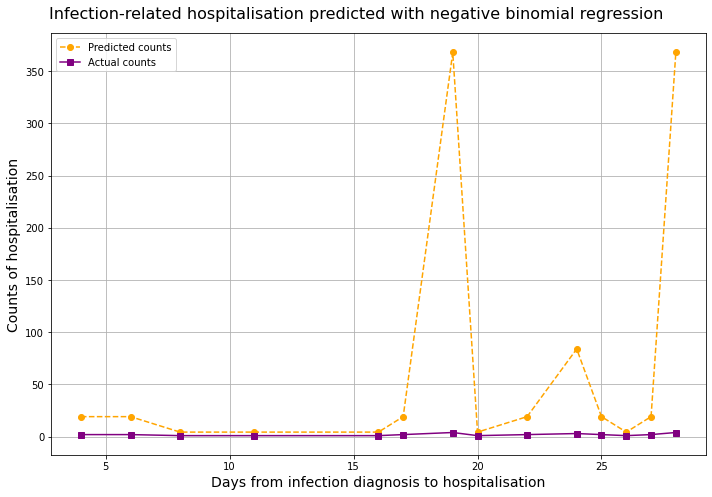

In [415]:
# NB_predicted_counts = nb2predictions_summary_frame['mean'].drop([0])*1000
NB_predicted_counts = nb2predictions_summary_frame['mean']#*1000
# actual_counts = y.drop([0])*1000
actual_counts = y#y#*1000

fig = plt.figure(figsize=(10, 7))
fig.suptitle('Infection-related hospitalisation predicted with negative binomial regression', fontsize=16)
predicted, = plt.plot(actual_counts, NB_predicted_counts, color='orange', ls='--', marker='o', label='Predicted counts',
                    #'go--', 
                    )
actual, = plt.plot(actual_counts, X.Infection_count, color='purple', ls='solid', marker='s', label='Actual counts'
                    #'ro-', 
                    )
#plt.ylim(-0.1,1.1)

# plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
# plt.axvline(x="2021-03", color='black', ls='--', lw=1.5)

plt.legend(handles=[predicted, actual])
# plt.xticks(rotation=90,) 
#             #ha='right')
plt.grid()
plt.ylabel('Counts of hospitalisation', fontsize='14')
plt.xlabel('Days from infection diagnosis to hospitalisation', fontsize='14')
# plt.ylim(0,10)
plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/NB2_hosp.jpg')
plt.show()

##### 3-4-3- Other plots

In [ ]:
# # see: https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLMResults.html

# # added variable plot for a fitted regression model
# nb2_training_results.plot_added_variable('age')

# nb2_training_results.plot_ceres_residuals('age')

# nb2_training_results.plot_partial_residuals('age')

In [348]:
# # #Influence Measures for GLM Logit
# # #https://www.statsmodels.org/stable/examples/notebooks/generated/influence_glm_logit.html

# NB2 = nb2_training_results.get_influence(observed=False)

# NB2_sum = NB2.summary_frame()
# NB2_sum.sort_values("cooks_d", ascending=False)[:10]

# # fig = NB2.plot_influence()
# # fig.tight_layout(pad=1.0)

# # fig = NB2.plot_index(y_var="cooks", threshold=2 * infl.cooks_distance[0].mean())
# # fig.tight_layout(pad=1.0)

# # fig = NB2.plot_index(y_var="resid", threshold=1)
# # fig.tight_layout(pad=1.0)

# # fig = NB2.plot_index(y_var="dfbeta", idx=1, threshold=0.5)
# # fig.tight_layout(pad=1.0)

# # fig = NB2.plot_index(y_var="dfbeta", idx=2, threshold=0.5)
# # fig.tight_layout(pad=1.0)

## Questions:
Q1- should we not exclude those who are admitted due to covid, not those who were diagnosed with covid 3 months before or two weeks after?

Q2- what is the difference between primary_care_covid and sgss_positive? seems like the first one is broader, right?

Q3- Data for NB2 model is not split into training and testing. Is it OK or it should be split?

Q4- I have used groupby to create data set for NB2. It calculates a mean value for each variable in each month. How is this gonna work with categorical variables?

Q5- If a patient gets hospitalise twice or more, I assume we consider the one that was closer to the infection diagnosis date, right?